In [55]:
# Данные и предсказания
import pandas as pd
import numpy as np
from fbprophet import Prophet
import pystan

import holidays

# Графики
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import warnings
warnings. simplefilter('ignore')

#import logging
#logging.getLogger('fbprophet').setLevel(logging.WARNING) 

In [56]:
df = pd.read_csv('aggregation_RU.csv')

In [57]:
df

,date,confirmed,deaths,recovered,region_name,region_code,isolation_start,level,self_isolation
0,2020-03-27,3.0,0.0,0.0,Архангельская область,RU-ARK,NaN,NaN,NaN
1,2020-03-27,4.0,0.0,0.0,Республика Башкортостан,RU-BA,NaN,NaN,NaN
2,2020-03-27,1.0,0.0,0.0,Белгородская область,RU-BEL,NaN,NaN,NaN
3,2020-03-27,2.0,0.0,0.0,Брянская область,RU-BRY,NaN,NaN,NaN
4,2020-03-27,2.0,0.0,0.0,Республика Бурятия,RU-BU,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
68560,2022-06-13,386655.0,8319.0,377027.0,Воронежская область,RU-VOR,NaN,NaN,NaN
68561,2022-06-13,137164.0,1042.0,135808.0,Ямало-Ненецкий автономный округ,RU-YAN,NaN,NaN,NaN
68562,2022-06-13,162394.0,2810.0,158757.0,Ярославская область,RU-YAR,NaN,NaN,NaN
68563,2022-06-13,18899.0,552.0,18212.0,Еврейская автономная область,RU-YEV,NaN,NaN,NaN


In [84]:
df = pd.read_csv('aggregation_RU.csv')
df = df.loc[df['region_code'] == 'RU-SAM']
df = df[['date', 'confirmed']]


In [85]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

<AxesSubplot:>

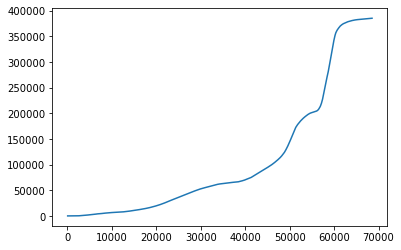

In [86]:
df['confirmed'].plot()

In [87]:
df.sort_values(by='date', inplace=True) 

In [88]:
df = df.drop_duplicates(subset=['date', 'confirmed'], keep='first')

In [89]:
df = df.reset_index(drop=True)

In [90]:
# Преобразим данные из комилитивных в ежидневные данные
df['daily_cases'] = df['confirmed'] - df['confirmed'].shift(fill_value=0)

In [91]:
df.head()

,date,confirmed,daily_cases
0,2020-03-27,12.0,12.0
1,2020-03-28,14.0,2.0
2,2020-03-29,14.0,0.0
3,2020-03-30,14.0,0.0
4,2020-03-31,15.0,1.0


### Сделаем прогноз для "накопительных" данных

<AxesSubplot:>

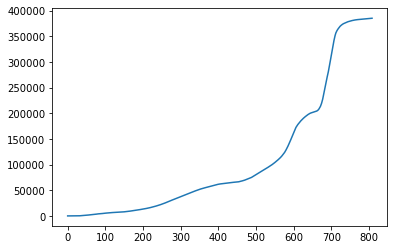

In [92]:
pr_1 = df[['date', 'confirmed']]
pr_1.columns = ['ds', 'y']
pr_1['y'].plot()


In [93]:
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RU(years=(2020, 2021, 2022))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.head()

,ds,holiday
0,2020-01-01,Новый год
1,2020-01-02,Новый год
2,2020-01-03,Новый год
3,2020-01-04,Новый год
4,2020-01-05,Новый год


In [94]:
df_holidays

,ds,holiday
0,2020-01-01,Новый год
1,2020-01-02,Новый год
2,2020-01-03,Новый год
3,2020-01-04,Новый год
4,2020-01-05,Новый год
5,2020-01-06,Новый год
6,2020-01-07,Православное Рождество
7,2020-01-08,Новый год
8,2020-02-23,День защитника отечества
9,2020-03-08,День женщин


In [95]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 5

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = pr_1[:-predictions]

In [96]:
# Настраиваем prophet – говорим ему учитывать праздники и сезонности
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
m.fit(train_df)

In [97]:
# Предсказываем 30 дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

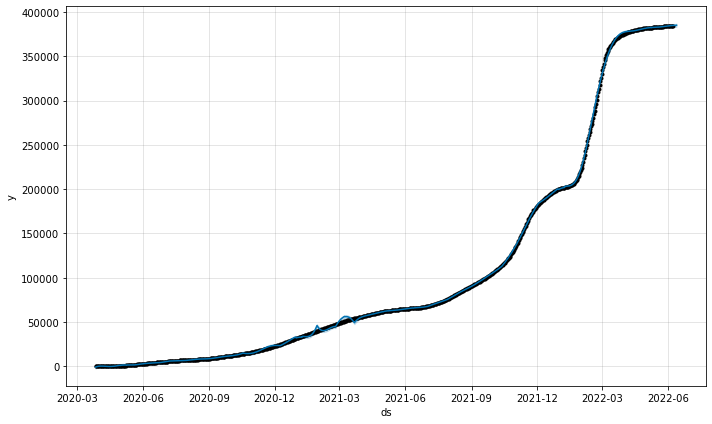

In [98]:
# Смотрим, что предсказалось
predict_forecast_plot = m.plot(forecast)

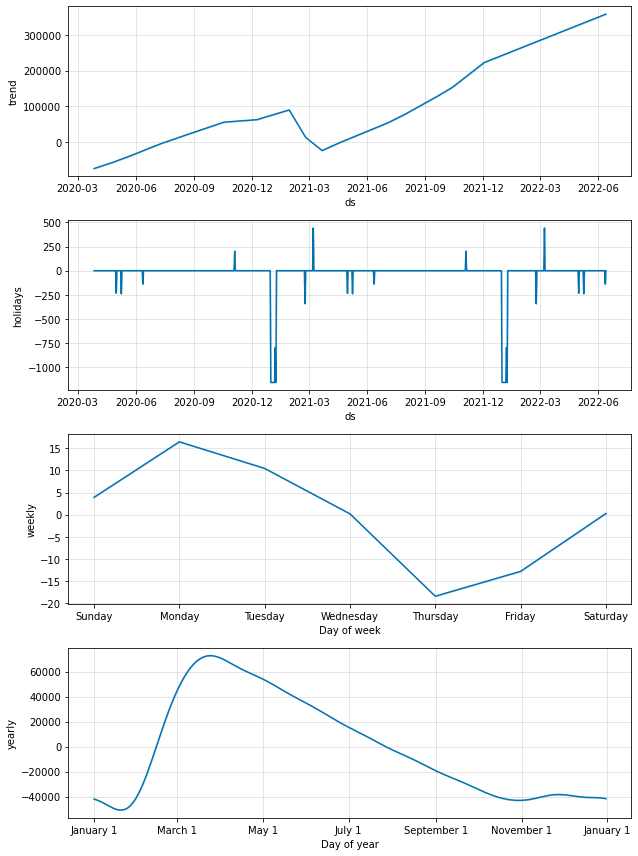

In [99]:
# Смотрим на сезонности
components = m.plot_components(forecast)

In [100]:
# Рисуем график с границами прогноза
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=pr_1['ds'], y=pr_1['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [75]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(pr_1.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  0.17627507987877436 %
MAE (средняя абсолютная ошибка) –  4888.7431357030755


### Сделаем прогноз для "ежидневных" сдучаев

<AxesSubplot:>

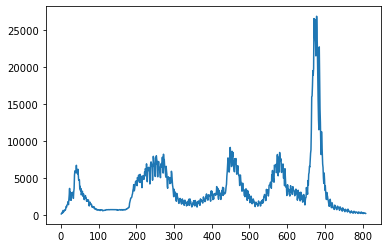

In [76]:
pr_2 = df[['date', 'daily_cases']]
pr_2 = pr_2.iloc[1:]
pr_2.columns = ['ds', 'y']
pr_2['y'].plot()

In [77]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 7

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = pr_2[:-predictions]

In [78]:
# Настраиваем prophet – говорим ему учитывать праздники и сезонности
m = Prophet(holidays=df_holidays, daily_seasonality = False, weekly_seasonality=True, yearly_seasonality=True)
m.fit(train_df)

In [79]:
# Предсказываем 30 дней
future = m.make_future_dataframe(periods=predictions)
forecast_2 = m.predict(future)

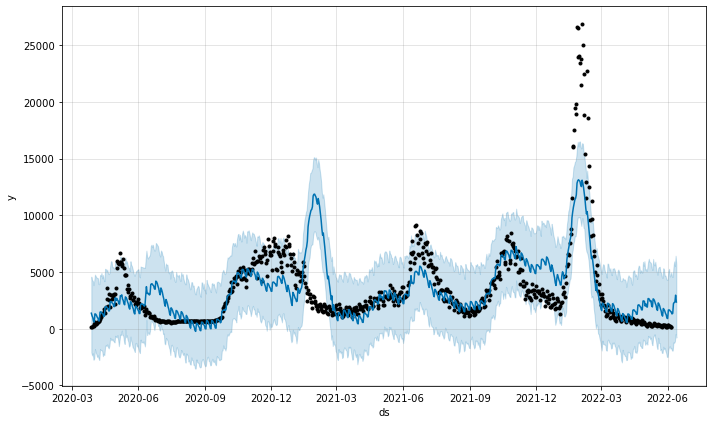

In [80]:
# Смотрим, что предсказалось
predict_forecast_plot = m.plot(forecast_2)

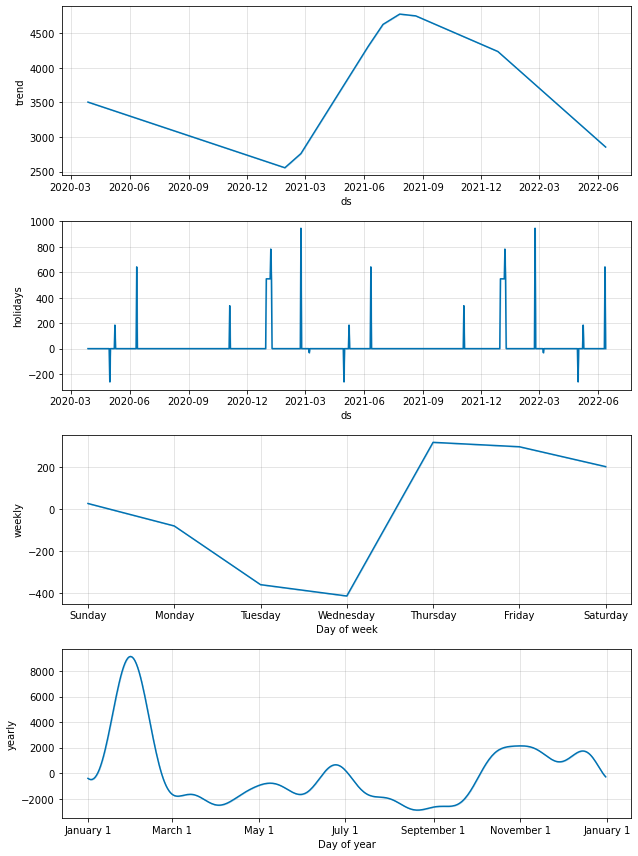

In [81]:
# Смотрим на сезонности
components = m.plot_components(forecast_2)

In [82]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=pr_2['ds'], y=pr_2['y'], name='fact'),
    go.Scatter(x=forecast_2['ds'], y=forecast_2['yhat'], name='prediction'),
    go.Scatter(x=forecast_2['ds'], y=forecast_2['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast_2['ds'], y=forecast_2['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast_2['ds'], y=forecast_2['trend'], name='trend')
])


In [83]:
# Смотрим на ошибки модели
cmp_df = forecast_2.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(pr_2.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  901.6843930367957 %
MAE (средняя абсолютная ошибка) –  1904.7888205453612
